# Task 2: Graph Generation on QM9 Dataset with DDPM


This notebook is adapted from the National University of Singapore CS5284 Graph Machine Learning course, the original tutorial code can be found at [here](https://github.com/xbresson/CS5284_2024/blob/main/codes/11_Graph_Generation/code06_solution.ipynb).

> Some sections are adapted from the generation of GPT-4o and o3-mini models.

In [ ]:
# For Google Colaboratory
import sys, os
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive/")
    path = "/content/drive/MyDrive/yanming_dissertation/gtv2/code/"
    os.chdir(path)
    !pwd
    !pip install dgl==1.0.0
    !pip install rdkit==2023.09.6

Mounted at /content/drive/
/content/drive/MyDrive/gt_v2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 41.0 MB/s eta 0:00:00


In [2]:
# Libraries
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import networkx as nx
import sys; sys.path.insert(0, "lib/")
from lib.molecules import Dictionary, MoleculeDataset, MoleculeDGL, Molecule, compute_ncut, from_pymol_to_smile
import os, datetime
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")
import numpy as np
import math

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda")
else:
  device= torch.device("cpu")
print(device)

2.5.1+cu124
Tesla T4
cuda


## Load Dataset

Loading data...
dataset/QM9/
Time: 6.1628 sec
num train data : 1000
atom_dict.idx2word : ['N', 'C', 'O', 'F', 'N H3 +', 'O -', 'C H1 -', 'N +', 'N -']
atom_dict.word2idx : {'N': 0, 'C': 1, 'O': 2, 'F': 3, 'N H3 +': 4, 'O -': 5, 'C H1 -': 6, 'N +': 7, 'N -': 8}
bond_dict.idx2word : ['NONE', 'SINGLE', 'DOUBLE', 'TRIPLE']
bond_dict.word2idx : {'NONE': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
9 4
train[idx].atom_type : tensor([1, 1, 1, 2, 1, 1, 2, 1, 1])
train[idx].atom_type_pe : tensor([0, 1, 2, 0, 3, 4, 1, 5, 6])
train[idx].bond_type : tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 1, 0]])
train[idx].bag_of_atoms : tensor([0, 7, 2, 0, 0, 0, 0, 0, 0])
train[idx].smile:  CC1C(O)C2C(O)CC12
train[idx].logP_SA tensor(

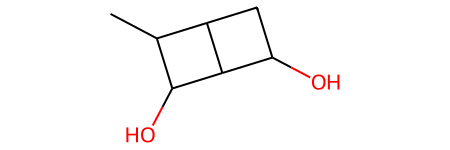

In [ ]:
print("Loading data...")
start = time.time()

data_folder_pytorch = "dataset/QM9/"
print(data_folder_pytorch)

with open(data_folder_pytorch+"atom_dict.pkl","rb") as f:
    atom_dict=pickle.load(f)
with open(data_folder_pytorch+"bond_dict.pkl","rb") as f:
    bond_dict=pickle.load(f)
with open(data_folder_pytorch+"train.pkl","rb") as f:
    train=pickle.load(f)
with open(data_folder_pytorch+"val.pkl","rb") as f:
    val=pickle.load(f)
with open(data_folder_pytorch+"test.pkl","rb") as f:
    test=pickle.load(f)

print(f"Time: {time.time() - start:.4f} sec")

print("num train data :", len(train))
print("num valid data :", len(val))
print("num test data :", len(test))

print("atom_dict.idx2word :", atom_dict.idx2word)
print("atom_dict.word2idx :", atom_dict.word2idx)
print("bond_dict.idx2word :", bond_dict.idx2word)
print("bond_dict.word2idx :", bond_dict.word2idx)

num_atom_type = len(atom_dict.idx2word)
num_bond_type = len(bond_dict.idx2word)
print(num_atom_type, num_bond_type)

idx = 0
print("train[idx].atom_type :", train[idx].atom_type)
print("train[idx].atom_type_pe :", train[idx].atom_type_pe)
print("train[idx].bond_type :", train[idx].bond_type)
print("train[idx].bag_of_atoms :", train[idx].bag_of_atoms)
print("train[idx].smile: ", train[idx].smile)
print("train[idx].logP_SA", train[idx].logP_SA)
mol = Chem.MolFromSmiles(train[idx].smile)
mol

## Dataset Statistics

### Grouping Molecules by Number of Atoms

In [5]:
# Organize data into group of of molecules of fixed sized
# Example: train[9] is a list containing all the molecules of size 9
def group_molecules_per_size(dataset):
    mydict = {}
    for mol in dataset:
        if len(mol) not in mydict:
            mydict[len(mol)] = []
        mydict[len(mol)].append(mol)
    return mydict

test_group  = group_molecules_per_size(test)
val_group   = group_molecules_per_size(val)
train_group = group_molecules_per_size(train)

# The biggest molecule in the train set
max_mol_sz= max(list( train_group.keys()))
print("Max num atoms = ", max_mol_sz)

# Print distribution w.r.t. molecule size
def print_distribution(data):
    for nb_atom in range(max_mol_sz+1):
        try:
            print("number of molecule of size {}: \t {}".format(nb_atom, len(data[nb_atom])))
        except:
            pass

print()
print("Train"); print_distribution(train_group)
print("Val"); print_distribution(val_group)
print("Test"); print_distribution(test_group)

Max num atoms =  9

Train
number of molecule of size 4: 	 1
number of molecule of size 5: 	 1
number of molecule of size 6: 	 7
number of molecule of size 7: 	 24
number of molecule of size 8: 	 136
number of molecule of size 9: 	 831
Val
number of molecule of size 7: 	 6
number of molecule of size 8: 	 28
number of molecule of size 9: 	 166
Test
number of molecule of size 6: 	 1
number of molecule of size 7: 	 3
number of molecule of size 8: 	 37
number of molecule of size 9: 	 159


### Sampling Molecules from Train Set through Possibility Distribution

In [6]:
class sample_molecule_size:
    def __init__(self, organized_dataset):
        self.num_mol = {sz: len(list_of_mol) for sz, list_of_mol in organized_dataset.items()}
        self.num_batches_remaining = {sz: self.num_mol[sz] for sz in self.num_mol}
    def choose_molecule_size(self):
        num_batches = self.num_batches_remaining
        possible_sizes = np.array( list( num_batches.keys()) )
        prob = np.array( list( num_batches.values() )   )
        prob = prob / prob.sum()
        sz = np.random.choice(  possible_sizes , p=prob )
        return sz

sampler_size = sample_molecule_size(train_group)
print('sampler_size.num_mol :',sampler_size.num_mol)
sz = sampler_size.choose_molecule_size()
print('sz :',sz)

sampler_size.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
sz : 8


## Generate Batches

### Implement the molecule sampler class for batch sampling of molecules

In [7]:
class MoleculeSampler:
    def __init__(self, organized_dataset, bs, shuffle=True):
        self.bs = bs
        self.num_mol =  {sz: len(list_of_mol) for sz, list_of_mol in organized_dataset.items()}
        self.counter = {sz: 0   for sz in organized_dataset}
        if shuffle:
            self.order = {sz: np.random.permutation(num)  for sz , num in self.num_mol.items()}
        else:
            self.order = {sz: np.arange(num)  for sz , num in self.num_mol.items()}

    def compute_num_batches_remaining(self):
        return {sz:  math.ceil(((self.num_mol[sz] - self.counter[sz])/self.bs))  for sz in self.num_mol}

    def choose_molecule_size(self):
        num_batches = self.compute_num_batches_remaining()
        possible_sizes = np.array(list(num_batches.keys()))
        prob = np.array(list(num_batches.values()))
        prob = prob / prob.sum()
        sz   = np.random.choice(possible_sizes, p=prob)
        return sz

    def is_empty(self):
        num_batches= self.compute_num_batches_remaining()
        return sum(num_batches.values()) == 0

    def draw_batch_of_molecules(self, sz):
        if (self.num_mol[sz] - self.counter[sz]) / self.bs >= 1.0:
            bs = self.bs
        else:
            bs = self.num_mol[sz] - (self.num_mol[sz] // self.bs) * self.bs
        indices = self.order[sz][self.counter[sz]:self.counter[sz] + bs]
        self.counter[sz] += bs
        return indices

### Extract one example mini-batch

In [8]:
# extract one mini-batch
bs = 50
sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :', sampler.num_mol)

num_batches_remaining = sampler.compute_num_batches_remaining()
print('num_batches_remaining :', num_batches_remaining)
sz = sampler.choose_molecule_size()
print('sz :', sz)
indices = sampler.draw_batch_of_molecules(sz)
print('indices :', len(indices), indices)
minibatch_node = torch.stack([train_group[sz][i].atom_type for i in indices])
print('minibatch_node :', minibatch_node.size())
minibatch_pe  = torch.stack([train_group[sz][i].atom_type_pe for i in indices])
print('minibatch_pe :', minibatch_pe.size())
minibatch_edge = torch.stack([ train_group[sz][i].bond_type for i in indices])
print('minibatch_edge :', minibatch_edge.size())
minibatch_boa = torch.stack([train_group[sz][i].bag_of_atoms for i in indices])
print('minibatch_boa :', minibatch_boa.size())

sampler.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining : {9: 17, 8: 3, 7: 1, 6: 1, 5: 1, 4: 1}
sz : 5
indices : 1 [0]
minibatch_node : torch.Size([1, 5])
minibatch_pe : torch.Size([1, 5])
minibatch_edge : torch.Size([1, 5, 5])
minibatch_boa : torch.Size([1, 9])


## DDPM Model

### Global Parameters

In [9]:
# Global constants
num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers = 6 # number of transformer layers
dPEt = d # number of dimensions for the time step of the diffusion model
drop = 0.0 # dropout value
bs = 10 # batch size

print('num_heads, d, num_layers, dPEt, drop, bs : ', num_heads, d, num_layers, dPEt, drop, bs)

beta_1 = 0.0001 # beta_1 for DM
beta_T = 0.02 # beta_T for DM
num_t = 150 # number of time steps of the DM
alpha_t = 1.0 - torch.linspace(beta_1, beta_T, num_t).to(device) # for DM, size=[num_t]
alpha_bar_t = torch.cumprod( alpha_t, dim=0) # for DM, size=[num_t]
print('beta_1, beta_T, num_t :', beta_1, beta_T, num_t)

# Warmup
num_mol_size = 20
num_warmup = 2 * max( num_mol_size, len(train) // bs ) # 4 epochs * max( num_mol_size=20, num_mol/batch_size)
print('num_warmup :',num_warmup)

num_heads, d, num_layers, dPEt, drop, bs :  4 128 6 128 0.0 10
beta_1, beta_T, num_t : 0.0001 0.02 150
num_warmup : 200


### Instantiate and test the model

In [10]:
from models.gtv1 import UNet_vanilla
from models.gtv2_weighted import UNet_weighted
from models.gtv2_gated import UNet_gated
from models.gtv2_mixed import UNet_mixed
from models.gtv2_film import UNet_film
from models.ddpm import DDPM

def sym_tensor(x):
    x = x.permute(0,3,1,2) # [bs, d, n, n]
    triu = torch.triu(x,diagonal=1).transpose(3,2) # [bs, d, n, n]
    mask = (triu.abs()>0).float()                  # [bs, d, n, n]
    x =  x * (1 - mask ) + mask * triu             # [bs, d, n, n]
    x = x.permute(0,2,3,1) # [bs, n, n, d]
    return x               # [bs, n, n, d]

# Instantiate the network
gt = UNet_film(d, num_heads, num_layers, num_atom_type, num_bond_type, num_t, max_mol_sz, dPEt, device, drop)
net = DDPM(num_t, beta_1, beta_T, gt, num_atom_type, num_bond_type, device).to(device)

def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.AdamW(net.parameters(), lr=init_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :',sampler.num_mol)
num_batches_remaining = sampler.compute_num_batches_remaining()
print('num_batches_remaining :',num_batches_remaining)
sz = sampler.choose_molecule_size()
print('sz :',sz)
indices = sampler.draw_batch_of_molecules(sz)
batch_x0 = minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
print('minibatch_node :',minibatch_node.size())
batch_e0 = minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
print('minibatch_edge :',minibatch_edge.size())
batch_sample_t = torch.randint(0, num_t, (batch_x0.size(0),)).long().to(device) # random interger in {0,1,...,T-1} [bs]
print('batch_sample_t',batch_sample_t.size())

bs2, n = batch_x0.size()
batch_noise_x_t = torch.randn(bs2,n,num_atom_type).to(device) # [bs, n, num_atom_type]
batch_noise_e_t = torch.randn(bs2,n,n,num_bond_type).to(device) # [bs, n, n, num_bond_type]
batch_noise_e_t = sym_tensor(batch_noise_e_t)

print('batch_noise_x_t',batch_noise_x_t.size(),'batch_noise_e_t',batch_noise_e_t.size())
x_t, e_t = net.forward_process(batch_x0, batch_e0, batch_sample_t, batch_noise_x_t, batch_noise_e_t) # [bs, n], [bs, n, n]
print('x_t',x_t.size(), 'e_t',e_t.size())

noise_pred_x_t, noise_pred_e_t = net.backward_process(x_t, e_t, batch_sample_t) # [bs, n], [bs, n, n]
print('noise_pred_x_t',noise_pred_x_t.size(),'noise_pred_e_t',noise_pred_e_t.size())

loss_DDPM = torch.nn.MSELoss()(noise_pred_x_t, batch_noise_x_t) + 1.0* torch.nn.MSELoss()(noise_pred_e_t, batch_noise_e_t)
loss = loss_DDPM
optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25) # grad_norm_clip=1.0
optimizer.step()

with torch.no_grad():
    batch_x_0, batch_e_0 = net.generate_process_ddpm(4, 9)
    print('batch_x_0',batch_x_0.size(), 'batch_e_0',batch_e_0.size())

del gt, net
torch.cuda.empty_cache()

Number of parameters: 2767629 (2.77 million)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


sampler.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining : {9: 84, 8: 14, 7: 3, 6: 1, 5: 1, 4: 1}
sz : 5
minibatch_node : torch.Size([1, 5])
minibatch_edge : torch.Size([1, 5, 5])
batch_sample_t torch.Size([1])
batch_noise_x_t torch.Size([1, 5, 9]) batch_noise_e_t torch.Size([1, 5, 5, 4])
x_t torch.Size([1, 5, 9]) e_t torch.Size([1, 5, 5, 4])
noise_pred_x_t torch.Size([1, 5, 9]) noise_pred_e_t torch.Size([1, 5, 5, 4])
batch_x_0 torch.Size([4, 9, 9]) batch_e_0 torch.Size([4, 9, 9, 4])


## Train And Evaluate The Model

### Training Loop

In [11]:
# Random seed
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

gt = UNet_film(d, num_heads, num_layers, num_atom_type, num_bond_type, num_t, max_mol_sz, dPEt, device, drop)
net = DDPM(num_t, beta_1, beta_T, gt, num_atom_type, num_bond_type, device).to(device)

# Optimizer
init_lr = 0.0003
optimizer = torch.optim.AdamW(net.parameters(), lr=init_lr)
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda t: min((t+1)/num_warmup, 1.0) ) # warmup scheduler
scheduler_tracker = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True) # tracker scheduler

# Number of mini-batches per epoch
nb_epochs = 100
num_warmup_batch = 0
print('num_heads, d, num_layers, dPEt, drop, bs : ', num_heads, d, num_layers, dPEt, drop, bs)
print('beta_1, beta_T, num_t :', beta_1, beta_T, num_t)
print('num_warmup, nb_epochs :',num_warmup, nb_epochs)

start = time.time()
for epoch in range(nb_epochs):
    running_loss = 0.0
    num_batches = 0
    net.train()
    sampler = MoleculeSampler(train_group, bs)
    count = 0
    while(not sampler.is_empty()):
        sz = sampler.choose_molecule_size()
        indices = sampler.draw_batch_of_molecules(sz)
        batch_x0 = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
        batch_e0 = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
        batch_sample_t = torch.randint(0, num_t, (batch_x0.size(0),)).long().to(device) # random interger in {0,1,...,T-1} [bs]
        bs2, n = batch_x0.size()
        batch_noise_x_t = torch.randn(bs2,n,num_atom_type).to(device) # [bs, n, num_atom_type]
        batch_noise_e_t = torch.randn(bs2,n,n,num_bond_type).to(device) # [bs, n, n, num_bond_type]
        batch_noise_e_t = sym_tensor(batch_noise_e_t)
        x_t, e_t = net.forward_process(batch_x0, batch_e0, batch_sample_t, batch_noise_x_t, batch_noise_e_t) # [bs, n], [bs, n, n]
        noise_pred_x_t, noise_pred_e_t = net.backward_process(x_t, e_t, batch_sample_t) # [bs, n], [bs, n, n]
        loss_DDPM = torch.nn.MSELoss()(noise_pred_x_t, batch_noise_x_t) + 1.0* torch.nn.MSELoss()(noise_pred_e_t, batch_noise_e_t)
        loss = loss_DDPM
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25) # grad_norm_clip=1.0
        optimizer.step()
        if num_warmup_batch < num_warmup:
            scheduler_warmup.step() # warmup scheduler
        num_warmup_batch += 1
        # Compute stats
        running_loss += loss.detach().item()
        num_batches += 1
    # Average stats
    mean_loss = running_loss/ num_batches
    if num_warmup_batch >= num_warmup:
        scheduler_tracker.step(mean_loss) # tracker scheduler defined w.r.t. loss value
    elapsed = (time.time()-start)/60
    print('epoch= %d \t time= %.4f min \t lr= %.7f \t loss= %.4f' % (epoch, elapsed, optimizer.param_groups[0]['lr'], mean_loss) )
    # Check lr value
    if optimizer.param_groups[0]['lr'] < 10**-6:
      print("\n lr is equal to min lr -- training stopped\n")
      break

num_heads, d, num_layers, dPEt, drop, bs :  4 128 6 128 0.0 10
beta_1, beta_T, num_t : 0.0001 0.02 150
num_warmup, nb_epochs : 200 100
epoch= 0 	 time= 0.2392 min 	 lr= 0.0001575 	 loss= 2.0997
epoch= 1 	 time= 0.4685 min 	 lr= 0.0003000 	 loss= 0.8702
epoch= 2 	 time= 0.7043 min 	 lr= 0.0003000 	 loss= 0.5315
epoch= 3 	 time= 0.9366 min 	 lr= 0.0003000 	 loss= 0.4405
epoch= 4 	 time= 1.1881 min 	 lr= 0.0003000 	 loss= 0.3861
epoch= 5 	 time= 1.4277 min 	 lr= 0.0003000 	 loss= 0.3588
epoch= 6 	 time= 1.6611 min 	 lr= 0.0003000 	 loss= 0.3345
epoch= 7 	 time= 1.8925 min 	 lr= 0.0003000 	 loss= 0.3189
epoch= 8 	 time= 2.1258 min 	 lr= 0.0003000 	 loss= 0.2702
epoch= 9 	 time= 2.3538 min 	 lr= 0.0003000 	 loss= 0.2557
epoch= 10 	 time= 2.5890 min 	 lr= 0.0003000 	 loss= 0.2628
epoch= 11 	 time= 2.8211 min 	 lr= 0.0003000 	 loss= 0.2401
epoch= 12 	 time= 3.0495 min 	 lr= 0.0003000 	 loss= 0.2071
epoch= 13 	 time= 3.2811 min 	 lr= 0.0003000 	 loss= 0.2074
epoch= 14 	 time= 3.5084 min 	 lr= 

### Validity of Generated Molecules

In [12]:
# compute percentage of valid molecules
def compute_perc_valid_molecules(net, sampler_size, num_gen_mol=1000, num_generated_mols_per_batch=100):
    num_batches = num_gen_mol // num_generated_mols_per_batch
    num_valid_mol = 0
    list_valid_mol = []
    list_mol = []
    start = time.time()
    for idx in range(num_batches):
        net.eval()
        net.UNet.eval()
        with torch.no_grad():
            num_atom_sampled = sampler_size.choose_molecule_size() # sample the molecule size
            print('num_atom_sampled :',num_atom_sampled)
            batch_x_0, batch_e_0 = net.generate_process_ddpm(num_generated_mols_per_batch, num_atom_sampled)
            batch_x_0 = torch.max(batch_x_0, dim=2)[1]  # [bs, n]
            batch_e_0 = torch.max(batch_e_0, dim=3)[1] # [bs, n, n]
            x_hat = batch_x_0.detach().to('cpu')
            e_hat = batch_e_0.detach().to('cpu')
            for x,e in zip(x_hat,e_hat):
                pymol = Molecule(num_atom_sampled, num_atom_type)
                pymol.atom_type = x
                pymol.bond_type = e
                smile = from_pymol_to_smile(pymol, atom_dict, bond_dict)
                list_mol.append(smile)
                mol = Chem.MolFromSmiles(smile)
                if mol is not None:
                    list_valid_mol.append(smile)
                    num_valid_mol += 1
    perc_valid_molecules = 100*num_valid_mol/num_gen_mol
    line = 'num_gen_mol= ' + str(num_gen_mol) + '   time(min)= ' + str((time.time()-start)/60)[:5] + '   perc valid molecules= ' + str(perc_valid_molecules)[:6]
    return perc_valid_molecules, list_mol, line, list_valid_mol

np.random.seed(0)
perc_valid_mol, list_mol, line, list_valid_mol = compute_perc_valid_molecules(net, sampler_size)
del gt, net
torch.cuda.empty_cache()
print('percentage of valid molecules')
print(line)

num_atom_sampled : 9
num_atom_sampled : 9
num_atom_sampled : 9
num_atom_sampled : 9
num_atom_sampled : 9
num_atom_sampled : 9
num_atom_sampled : 9
num_atom_sampled : 8
num_atom_sampled : 8
num_atom_sampled : 9
percentage of valid molecules
num_gen_mol= 1000   time(min)= 0.845   perc valid molecules= 48.1


### Uniqueness of Generated Molecules

In [13]:
print('num_generated_mol',len(list_mol))
num_unique_mol = 0
for idx,mol in enumerate(list_mol):
    list_tmp = list_mol.copy()
    list_tmp.pop(idx)
    if mol not in list_tmp:
        num_unique_mol += 1
print('num_unique_mol, num_mol:',num_unique_mol, len(list_mol))
perc_unique_mol = 100*num_unique_mol/len(list_mol)
print('perc unique molecules among the generated molecules:', str(perc_unique_mol)[:6])

num_generated_mol 1000
num_unique_mol, num_mol: 1000 1000
perc unique molecules among the generated molecules: 100.0


## Performance Comparison

Training was conducted over 100 epochs on a small subset of the QM9 dataset (1,000 training samples and 200 testing samples) with a fixed random seed. The results presented are the mean loss (and standard deviation) from the last 10 epochs, the percentage of valid molecules, the percentage of unique molecules, and the time taken to train the model.


|     Network      | Train Loss on QM9  |   Valid   | Unique | Time (min) |
| :--------------: | :----------------: | :-------: | :----: | :--------: |
|      GTv1       |   0.0798(0.0067)   |   39.2%   | 100.0% |  11.3804   |
| GTv2 (Weighted) |   0.0759(0.0023)   |   46.0%   | 99.8%  |  19.7241   |
|  GTv2 (Gated)   |   0.0766(0.0026)   |   37.0%   | 100.0% |  22.0124   |
|  GTv2 (Mixed)   | **0.0757**(0.0027) |   39.7%   | 100.0  |  20.6671   |
|   GTv2 (FiLM)   |   0.0778(0.0034)   | **48.1%** | 100.0% |  23.1486   |

## References

1. [Vijay Prakash Dwivedi and Xavier Bresson. "A generalization of transformer networks to graphs." *arXiv preprint arXiv:2012.09699* (2020).](https://arxiv.org/abs/2012.09699)

2. [Jonathan Ho, Ajay Jain and Pieter Abbeel. "Denoising diffusion probabilistic models." Advances in neural information processing systems 33 (2020): 6840-6851.](https://proceedings.neurips.cc/paper/2020/hash/4c5bcfec8584af0d967f1ab10179ca4b-Abstract.html)

3. [Ethan Perez, Florian Strub, Harm de Vries, Vincent Dumoulin and Aaron Courville. "Film: Visual reasoning with a general conditioning layer." In Proceedings of the AAAI conference on artificial intelligence, vol. 32, no. 1. 2018.](https://ojs.aaai.org/index.php/AAAI/article/view/11671)